In [154]:
import pandas as pd
import copy as cp
import GPy
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import numpy as np
%pylab inline
import pylab as pb
pylab.ion()
jtplot.style(theme='default')

Populating the interactive namespace from numpy and matplotlib


# Unidades de las tablas
<br><br>
## Archivo: 000 Analisis_Produccion-consumos CUAS.xlsx
<br><br>

### Primera tabla:
Esta tabla es de produccion de cobre
* Toneladas de cobre fino producido
<br><br>

### Segunda tabla:
Esta tabla es de produccion de cobre, pero separado por tamaño de la mina:
* Toneladas de cobre fino producido
<br><br>

### Tercera tabla:
Esta tabla es lo que consumimos de acido, considerando lo producido más lo importado (uno en cada fila):
* Toneladas de acido

## Archivo: 000 Analisis_Produccion-consumos CUAS.xlsx


In [282]:
# cargar Hoja1 del archivo: 000 Analisis _ Produccion-consumos CUAS.xlsx
# para crear los dataframes con produccion de fino y consumo de acido en
# indexados por el tiempo

folder = '/Users/juanpablodonosomerlet/Desktop/estudio-acidos/data/'
xls = pd.ExcelFile(folder + '000 Analisis _ Produccion-consumos CUAS.xlsx')
df1 = pd.read_excel(xls, 'Hoja1')
nombres_df1 = list(df1.columns.values)


In [83]:
# funcion para plotear multi-task GP (Ricardo Andrade-Pacheco)
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],ax=ax1)
    # ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],ax=ax2)
    # ax2.plot(t_cu_fino[:,:1],prod_fino,'kx',mew=1.5,label='Train set')
    # ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

In [283]:
# tabla1: produccion de fino, toda la informacion
tabla1 = df1.loc[:7,nombres_df1[2:18]]
tabla1 = tabla1.dropna()
tabla1.iloc[0].apply(int)
años = tabla1.iloc[0].apply(int)
dicc_years = {}
for i,year in enumerate(años):
    dicc_years[nombres_df1[2:18][i]] = year
tabla1 = tabla1.rename(dicc_years, axis='columns').loc[1:,:]
tabla1 = tabla1.append(tabla1.sum(), ignore_index=True)

# tabla2: consumo de acido
tabla2 = df1.loc[60:,nombres_df1[2:24]]
años2= tabla2.iloc[0].apply(int)
dicc_years2 = {}
for i,year in enumerate(años2):
    dicc_years2[nombres_df1[2:24][i]] = year
tabla2 = tabla2.rename(dicc_years2, axis='columns').loc[61:,:]

# tabla2: Leyes promedio de cobre anuales
xls_leyes = pd.ExcelFile(folder + 'Leyes Cu.xlsx')
hoja_leyes = xls_leyes.sheet_names[0]
df_leyes = pd.read_csv(folder+'leyes.csv')
# xls_leyes.sheet_names[3]

In [284]:
# dataframe de la produccion anual de fino 
produccion_fino = pd.DataFrame(tabla1.loc[6,:], index=list(tabla1.columns.values))
produccion_fino = produccion_fino.rename({6:'Produccion Cu fino anual'}, axis='columns')

# dataFrame del consumo total de acido
consumo_acido = tabla2.transpose()
consumo_acido = consumo_acido.rename({61:'Produccion',
                                      62:'Importaciones',63:'Total'}, axis='columns')


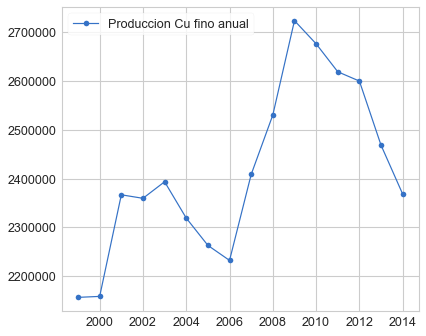

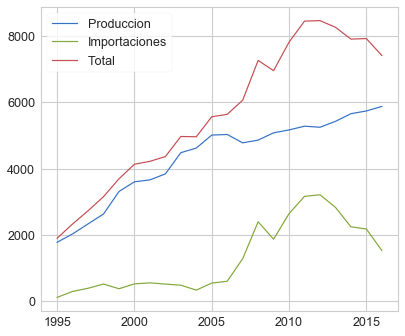

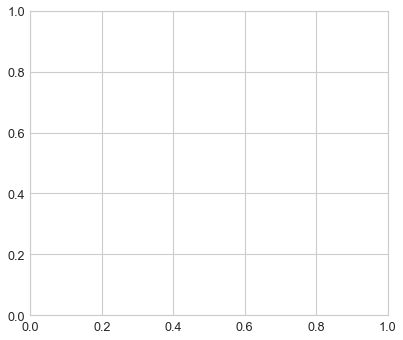

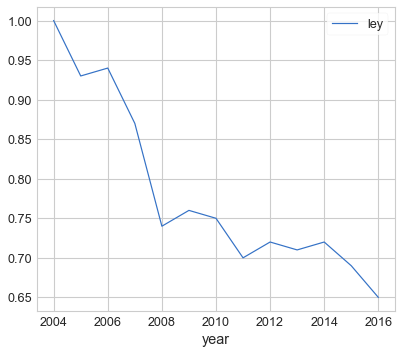

In [161]:
# fig, ax = plt.subplot()
figura, axe = plt.subplots(nrows=1, ncols=1)
produccion_fino.plot(style='bo-', ax=axe, grid=True)

figura, axe = plt.subplots(nrows=1, ncols=1)
consumo_acido.plot(ax=axe, grid=True)
plt.show()

figura, axe = plt.subplots(nrows=1, ncols=1)
df_leyes.set_index('year').plot()
plt.show()

In [298]:
# multitask gaussian process
# datos de fino como matrices
t_cu_fino = produccion_fino.index.values
t_cu_fino = np.reshape(t_cu_fino,newshape=(t_cu_fino.shape[0],1))
prod_fino = produccion_fino.as_matrix()

# datos de acido como matrices
t_ac = consumo_acido.index.values
t_ac = np.reshape(t_ac, newshape=(t_ac.shape[0],1))
prod_ac = consumo_acido.Produccion.as_matrix()
prod_ac = np.reshape(prod_ac, newshape=(prod_ac.shape[0],1))
consumo_ac = consumo_acido.Total.as_matrix()
# imp_ac = consumo_acido.Importaciones.as_matrix()

# datos de ley como matrices
t_leyes = df_leyes.year.as_matrix()
t_leyes = np.reshape(t_leyes, newshape=(t_leyes.shape[0],1))
leyes = df_leyes.ley.as_matrix()
leyes = np.reshape(leyes, newshape=(leyes.shape[0],1))

In [219]:
prod_ac.dtype

dtype('O')

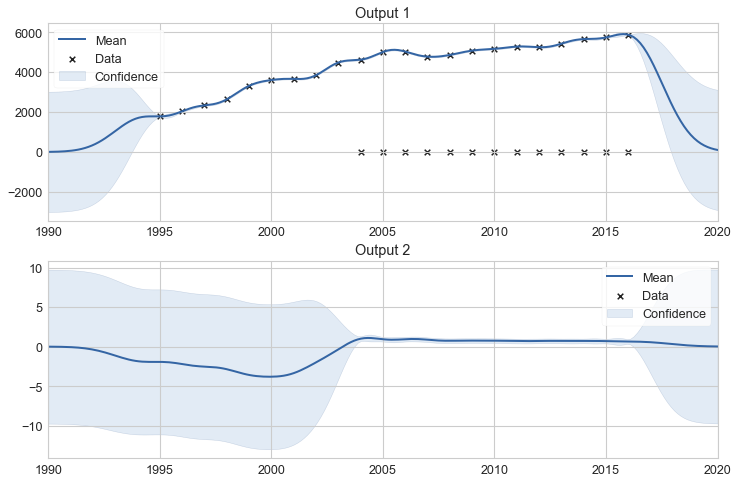

In [241]:
# definicion del kernel
K = GPy.kern.RBF(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)
modelo = GPy.models.GPCoregionalizedRegression([t_ac,t_leyes],[prod_ac, leyes])
modelo.optimize()

# graficar resultados
plot_2outputs(modelo, (1990, 2020), (0, 15000))

In [171]:
t_ac.shape

(22, 1)

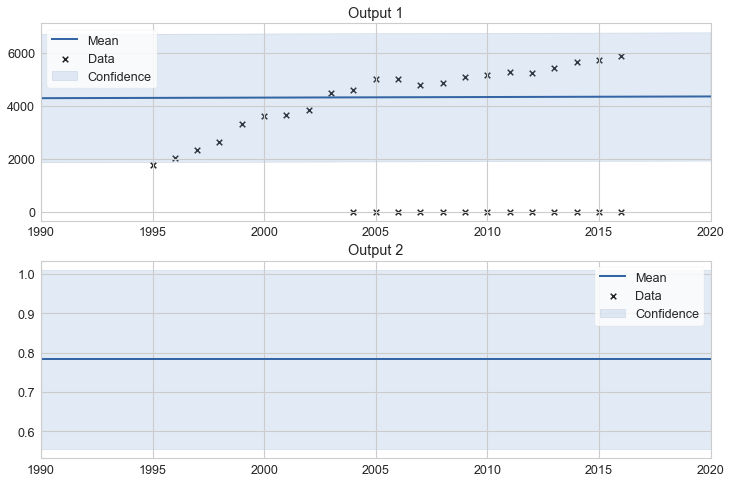

In [164]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([t_ac,t_leyes],[prod_ac,leyes],kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()

plot_2outputs(m,(1990, 2020), (0, 15000))

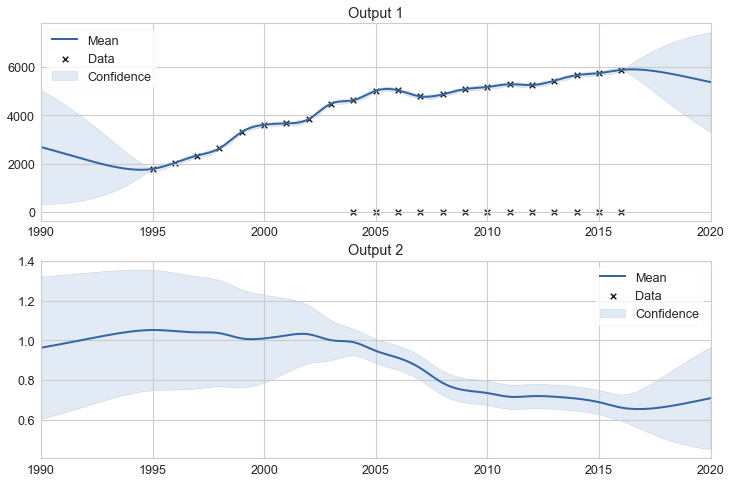

In [165]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([t_ac,t_leyes],[prod_ac,leyes],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,(1990, 2020), (0, 15000))

In [ ]:
# produccion de fino proveniente de sx-EW
# agregar produccion de fino 2014-2016(quizas 2017)
# Hacer las correlaciones con Produccion de fino
# agragar como dato estimaciones de fino en los años 2020, 2025, 2030
# Probar diferentes combinaciones entre los datos
# hacer funcion que agregre datos de produccion de fino!!!

In [308]:
# Datos finales para las predicciones
xls_final = pd.ExcelFile(folder + '000 Datos Finales para analisis.xlsx')
df_datos_finales = pd.read_excel(xls_final, 'Datos',header=0,index_col=1)
t_cu_fino

array([[1995],
       [1996],
       [1997],
       [1998],
       [1999],
       [2000],
       [2001],
       [2002],
       [2003],
       [2004],
       [2005],
       [2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022],
       [2023],
       [2024],
       [2025],
       [2026],
       [2027],
       [2028],
       [2029],
       [2030]])

In [307]:
# datos de produccion de fino por tonelada
t_cu_fino = df_datos_finales.index.values
t_cu_fino = np.reshape(t_cu_fino,newshape=(t_cu_fino.shape[0],1))
t_cu_fino = t_cu_fino[:-5,0]
t_cu_fino = np.reshape(t_cu_fino, newshape=(t_cu_fino.shape[0],1))
prod_fino_final = df_datos_finales['Produccion Catodo\nton'].as_matrix()
prod_fino_final = np.reshape(prod_fino_final, newshape=(prod_fino_final.shape[0],1))
prod_fino_final = prod_fino_final[:-5,0]
prod_fino_final = np.reshape(prod_fino_final, newshape=(prod_fino_final.shape[0],1))


# datos de consumo de acido 
t_ca = df_datos_finales.loc[df_datos_finales.index.values<=2017].index.values
t_ca = np.reshape(t_ac, newshape=(t_ac.shape[0],1))
consumo_ac_final = df_datos_finales['Consumo Acido\nton'].loc[df_datos_finales.index.values<=2017].as_matrix()
consumo_ac_final = np.reshape(consumo_ac_final, newshape=(consumo_ac_final.shape[0],1))

# datos para la produccion de acido
t_pa = df_datos_finales.loc[df_datos_finales.index.values<=2017].index.values
t_pa = np.reshape(t_pa, newshape=(t_pa.shape[0],1))
prod_ac_final = df_datos_finales['Produccion de Acido'].loc[df_datos_finales.index.values<=2017].as_matrix()
prod_ac_final = np.reshape(prod_ac_final, newshape=(prod_ac_final.shape[0],1))

# datos para la ley de cobre
t_leyes = df_datos_finales.loc[(df_datos_finales.index.values>=2003) & (df_datos_finales.index.values<=2016)].index.values
t_leyes = np.reshape(t_leyes, newshape=(t_leyes.shape[0],1))
leyes_final = df_datos_finales['LEYES\nPromedios'].loc[(df_datos_finales.index.values>=2003) & (df_datos_finales.index.values<=2016)].as_matrix()

In [314]:
# considerar el modelo con consumo de ac, produccion de catodo, y leyes

K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([t_pa,t_cu_fino],[prod_ac_final,prod_fino_final],kernel=lcm)
#modelo = GPy.models.GPCoregionalizedRegression([t_ac,t_leyes],[prod_ac, leyes])

 /Users/juanpablodonosomerlet/anaconda3/lib/python3.6/site-packages/GPy/likelihoods/gaussian.py:111: RuntimeWarning:invalid value encountered in sqrt


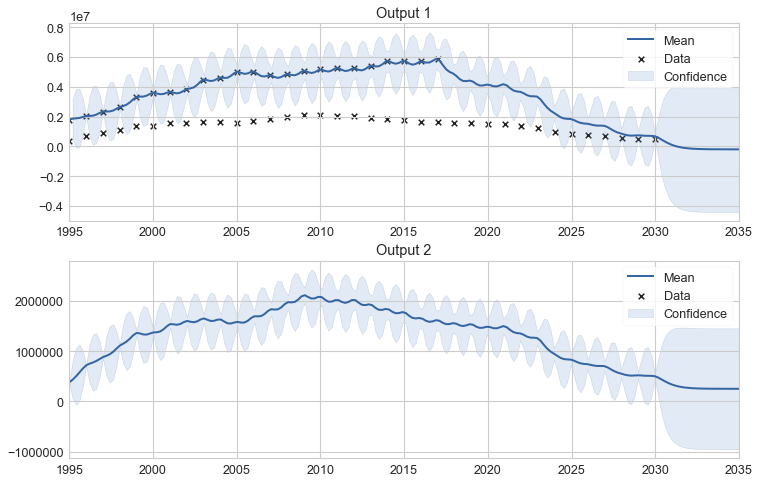

In [321]:
# considerar el modelo con consumo de ac, produccion de catodo, y leyes

K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([t_pa,t_cu_fino],[prod_ac_final,prod_fino_final],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,(1995, 2035), (0, 10))